In this tutorial, we will show the capabilities of the package applying it to a single-cell analysis dataset.

For this tutorial we consider to have already obtained the PCA and KNN graph of the dataset and now we want to cluster the data and find communities using (Leiden)[https://leidenalg.readthedocs.io/en/stable/intro.html] algorithm.

We load the necessary packages, including the `treeclust` package.

In [178]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib

# !pip install scanpy
# !pip install leidenalg
# !pip install scikit-network
# !pip install cairocffi

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sp
import leidenalg
import treeclust as tc

And the dataset we are going to analyize.

In [180]:
adata = sp.read_h5ad("./data/pijuan_E6.5_1_processed.h5ad")
adata.obsm['X_pca'].shape

(301, 100)

<Axes: >

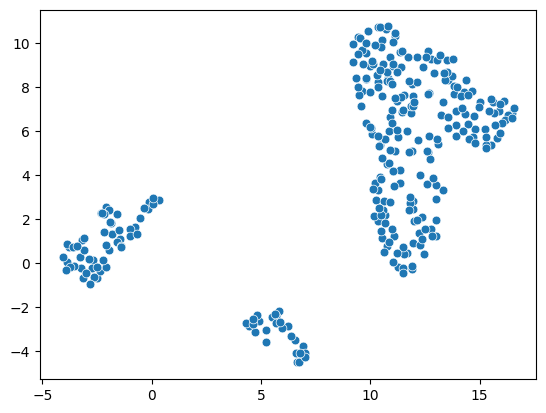

In [181]:
sns.scatterplot(
    x = adata.obsm["X_umap_pca"][:,0],
    y = adata.obsm["X_umap_pca"][:,1],
    s = 40
)

# Create model and train

The initialization of the model is very similar to those of the sklearn.

In [182]:
model = tc.RobustClusteringLeiden(
        #Graph representation, necessary for the leiden clustering
        connectivity_matrix=adata.obsp["neighbors_pca_connectivities"],
        X=adata.obsm['X_pca'],
        parameter_range=(0,2),
        n_clusters_max=50
)

16it [00:00, 118.48it/s]
185it [00:02, 77.20it/s, resolution_parameter=0.000977]


And one create we can fit it.

In [183]:
model.fit()

 58%|█████▊    | 15/26 [00:03<00:02,  3.84it/s]


As you can see the method stops before going over all the parameter range because of the early stop criteria.

# Visualize tree clustering

Now we can visualize the tree structure of partitions found by the algorithm. We can put the y position, color and size using different metrics. In this case, since we have just two metrics, we will use just the `connectivity_probability` as a metric for everything.

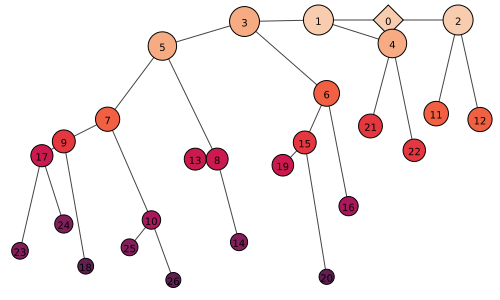

In [184]:
model.plot_graph(
    y = "connectivity_probability",
    color = "connectivity_probability",
    size = "connectivity_probability",
    size_norm=(30,15),
    bbox=(500,300),
    invert=True
)

This tree represents all the nested clusters partitions found by the algorithm. To make predictions of the clustering we will need to specify a partition configuration of our interest. The current partition is defined by the diamonds and by default starts in the single-cluster partition (cluster 0). 

When we run `model.predict()`, it will predict this will just return the single cluster label for all elements.

<Axes: >

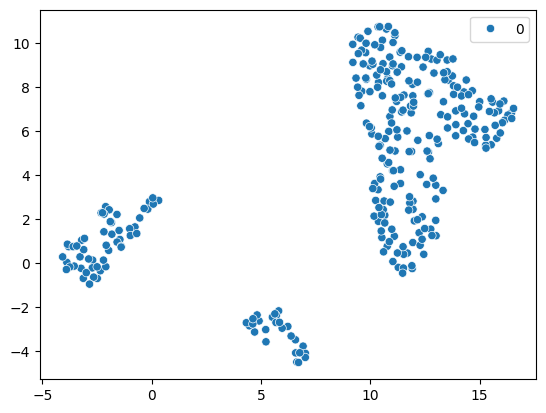

In [185]:
sns.scatterplot(
    x = adata.obsm["X_umap_pca"][:,0],
    y = adata.obsm["X_umap_pca"][:,1],
    hue = model.predict()
)

# Selecting a clustering candidate

To select another partition, we can call `model.set_threshold(metric, threshold)` to select the clusters based on this metric criteria. 

In [186]:
model.set_threshold(
    metric = "connectivity_probability",
    threshold=0.5
)

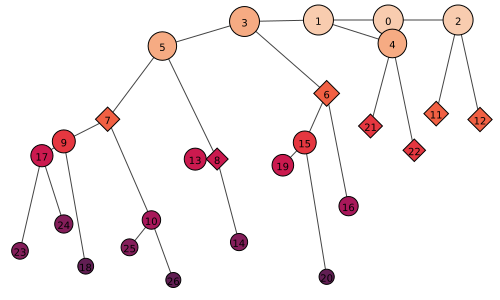

In [187]:
model.plot_graph(
    y = "connectivity_probability",
    color = "connectivity_probability",
    size = "connectivity_probability",
    size_norm=(30,15),
    bbox=(500,300),
    invert=True
)

Now we can see that the method indicates a new active partition.

> NOTE: 
> The way the method works is that method removes all the nodes below the threshold and then takes those nodes that are closer to a bifurcation.
> For example, in this specific case, clusters 17, 9 and 7 have a `connectivity_probability` above 0.5, however, 23, 24, 18, 10 and 8 do not and 5 is the closest node to a bofurcation in that branch.

We can visualize the new partition using the `model.predict()` or the soft version `model.predict_probability()` from which we show the probability to the most probable cluster.

/tmp/ipykernel_9208/1026707463.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


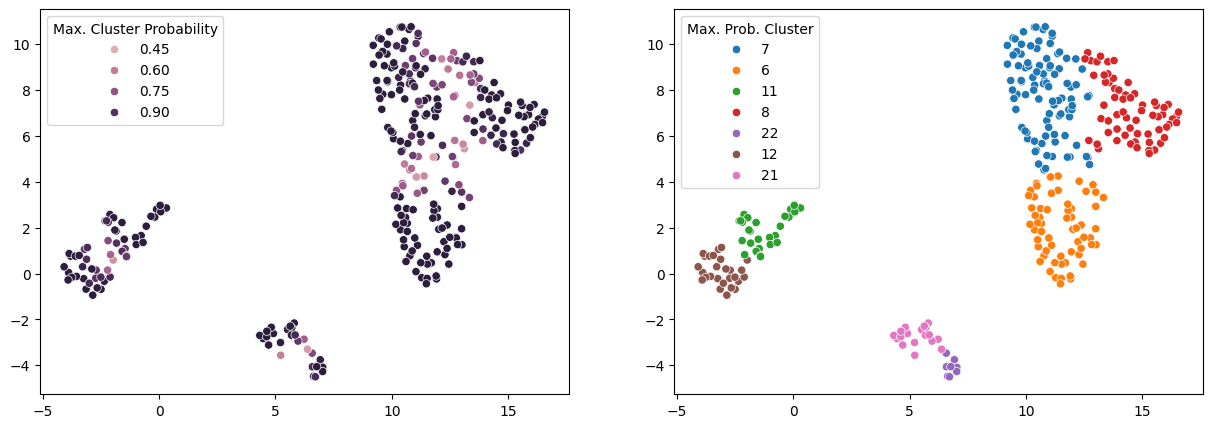

In [188]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(
    x = adata.obsm["X_umap_pca"][:,0],
    y = adata.obsm["X_umap_pca"][:,1],
    hue = model.predict_probability().max(axis=1),
    ax=ax[0]
)
ax[0].legend(title="Max. Cluster Probability")

sns.scatterplot(
    x = adata.obsm["X_umap_pca"][:,0],
    y = adata.obsm["X_umap_pca"][:,1],
    hue = model.predict().astype(str),
    ax=ax[1]
)
ax[1].legend(title="Max. Prob. Cluster")

fig.show()

# Metric score for the partition

In [191]:
model._active_clusters

array([11, 12,  8,  7,  6, 21, 22])

In [201]:
c=model._metrics['connectivity_probability']

m=c[:,model._active_clusters]
len(m[:,6][m[:,6]>0])

16

In [217]:
(model.predict()==22).sum()


9

In [202]:
len(model.predict()[model.predict()==6])

61

In [124]:
sc = np.zeros([1,len(model._active_clusters)])
sc[:,0]=1
sc

array([[1., 0., 0., 0., 0., 0.]])

In [155]:
from sklearn.metrics import silhouette_score

silhouette_score(model.X, model.predict())


0.08437087

In [315]:
n = np.zeros([1,len(model._active_clusters)])

for i,j in enumerate(model._active_clusters):
    idx=model.predict()==j
    mean_p=model.predict_probability().max(axis=1)[idx].mean()

    n[:,i] = mean_p

n_=n.mean()

sil = silhouette_score(model.X, model.predict())


In [316]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

In [317]:
df1=n
df1

array([[0.95098783, 0.94202004, 0.91379338, 0.91830965, 0.94478931,
        0.92000469, 0.95093287]])

In [318]:
x0,y0 = np.meshgrid(np.arange(df1.shape[1]), np.arange(df1.shape[0]))
for xi,yi in zip(x0.flat,y0.flat):
    print(xi,yi)

0 0
1 0
2 0
3 0
4 0
5 0
6 0


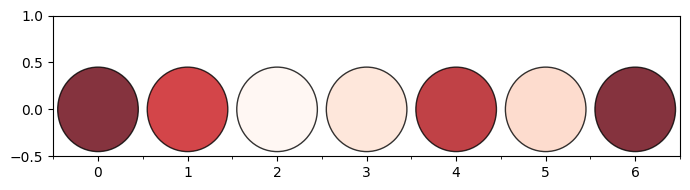

In [329]:
fig, ax = plt.subplots(1,1, figsize=(7,2),layout='tight')

x0,y0 = np.meshgrid(np.arange(df1.shape[1]), np.arange(df1.shape[0]))
patches0=[]

for xi,yi in zip(x0.flat,y0.flat):
    #R = df1[0][xi]/df1[0].max()/2
    R=1/2*0.9
    circle=plt.Circle((xi,yi),radius=R, edgecolor='black', lw=2)
    patches0.append(circle)

col0 = PatchCollection(patches=patches0, array=df1[0],cmap="Reds", ec='black', alpha=0.8)
ax.add_collection(col0)
ax.set_xticks(np.arange(df1.shape[1]+1)-0.5, minor=True)
#ax.set_xticks(np.arange(df1.shape[1]+1)-0.5, minor=True)
ax.set_yticks(np.arange(df1.shape[0])-0.5, minor=True)


In [258]:
patches0

In [236]:
model.predict_probability().max(axis=1)[m].mean()


0.9447893081682678

In [148]:
t=model._metrics['silhouette_scoring']
t=np.concatenate(t)

In [330]:
model._ac

array(['7', '6', '11', '8', '8', '7', '7', '22', '7', '8', '7', '12', '6',
       '8', '8', '7', '6', '11', '6', '7', '8', '12', '8', '7', '6', '11',
       '6', '11', '6', '7', '11', '12', '8', '7', '8', '6', '6', '12',
       '6', '7', '12', '21', '21', '12', '6', '8', '8', '7', '22', '7',
       '7', '8', '6', '8', '7', '6', '7', '11', '7', '12', '21', '7', '7',
       '7', '12', '6', '8', '6', '7', '11', '7', '12', '21', '6', '8',
       '6', '7', '12', '6', '12', '7', '21', '8', '12', '7', '6', '11',
       '6', '21', '6', '6', '8', '11', '8', '7', '7', '7', '12', '8', '8',
       '7', '7', '6', '6', '7', '7', '7', '11', '7', '11', '6', '8', '7',
       '7', '7', '7', '7', '7', '6', '7', '11', '7', '7', '7', '6', '12',
       '8', '6', '21', '21', '8', '8', '6', '7', '22', '12', '7', '11',
       '8', '6', '11', '7', '7', '7', '6', '22', '21', '8', '7', '6', '7',
       '6', '8', '7', '12', '7', '7', '21', '11', '7', '11', '7', '8',
       '8', '12', '7', '7', '12', '7', '7', '6',

<Axes: >

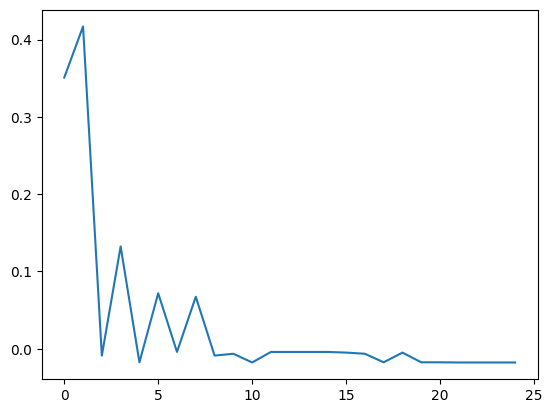

In [150]:
sns.lineplot(x=range(len(t)),y=t)

# Refining partition

Even if we have several methods and threshold criteria, using a single metric to select a relevant partition can be challenging. The package adds the possibility to fine tune the chosen partition by splits and merges of the clusters in the currect active partition.

In [25]:
#model.split(6) #this splits cluster 6 to 15 and 16
model.merge(8) #this considers merging of 13 and 14 back into 2

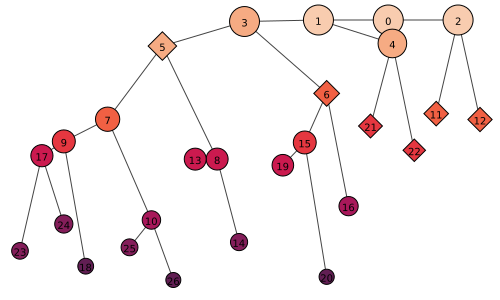

In [26]:
model.plot_graph(
    y = "connectivity_probability",
    color = "connectivity_probability",
    size = "connectivity_probability",
    size_norm=(30,15),
    bbox=(500,300),
    invert=True
)

/tmp/ipykernel_9208/1026707463.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


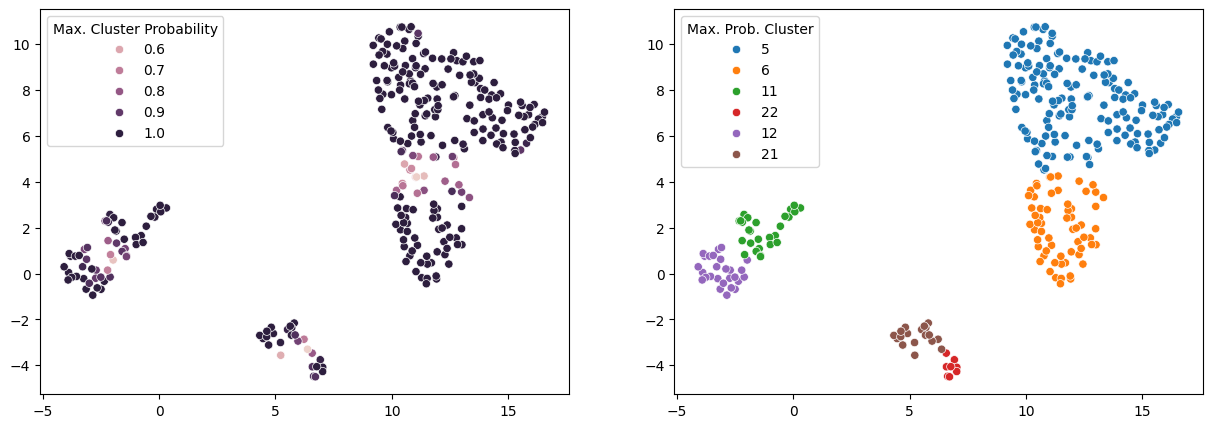

In [27]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(
    x = adata.obsm["X_umap_pca"][:,0],
    y = adata.obsm["X_umap_pca"][:,1],
    hue = model.predict_probability().max(axis=1),
    ax=ax[0]
)
ax[0].legend(title="Max. Cluster Probability")

sns.scatterplot(
    x = adata.obsm["X_umap_pca"][:,0],
    y = adata.obsm["X_umap_pca"][:,1],
    hue = model.predict().astype(str),
    ax=ax[1]
)
ax[1].legend(title="Max. Prob. Cluster")

fig.show()

# Annotation

Finally, to help giving identities to the different clusters, we can use the partitions along with additional information to name the clusters.

## Prepare an annotation dict

This is a dictionary that contains names and genes associated with each category.

In [28]:
annotation_dict = {
        "Ex. Ect.":{
            "genes":["Bmp4", "Sox2", "Id2", "Sfn", "Cdx2", "Wnt6", "Eomes", "Tfap2c", "Hand1", "Epcam", "Cdh1"],
        },
        "Ex. End.":{
            "genes":["Cubn", "Slc2a2", "Cited1"],
        },
        "V.E.":{
            "genes" : ["Apoe", "Fgf5", "Car4", "Apoa1", "Slc16a1", "Ctsc", "Eomes", "Sox17", "Lhx1","Cer1", "Pitx2", "Foxa2"],
            "AVE" :["Lefty1", "Hesx1", "Otx2", "Krt8", "Ctsc"],
        },
        "Epi.":{
            "genes":["Sox2", "Pou5f1","Fgf5","Slc7a3"],
        },
        "P. Epi.":{
                "genes":["T", "Fgf8", "Fst", "Wnt3", "Nanog"],
            },
        "A. Epi.":{
                "genes":["Pou3f1", "Otx2", "Kpna2", "Utf1", "Tcf15"],
            }
    }

gene_list = []
for i,j in annotation_dict.items():
    gene_list += j["genes"]
gene_list = np.unique(gene_list)

## Prepare the marker gene matrix

In addition, we need a pandas DataFrame which contains `elements x genes` used for the annotation.

In [ ]:
marker_genes = pd.DataFrame(adata[:,gene_list].X.todense(), columns=gene_list)

## Score the clusters

Finally we can generate the scoring.

In [ ]:
scoring = model.score_annotation(annotation_dict, marker_genes)

/tmp/ipykernel_349624/138229237.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


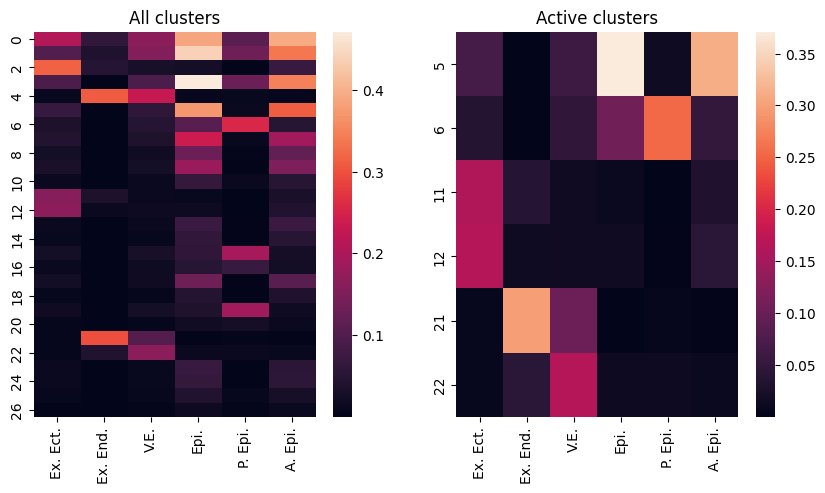

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.heatmap(scoring, ax=ax[0])
ax[0].set_title("All clusters")

sns.heatmap(scoring.iloc[np.sort(model._active_clusters),:], ax=ax[1])
ax[1].set_title("Active clusters")

fig.show()